In [1]:
import learn2learn as l2l
import numpy as np
import os
import torch
from torch.nn import Module, Linear, Sequential, ReLU
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [2]:
%run -i ./scripts/setConfigs.py

Set configs..


In [3]:
fn = os.path.join(data_path, 'drifted_data_y_2023_reduced.h5')
df_data = pd.read_hdf(fn, key='df')
print('Shape of drifted data: {}'.format(df_data.shape))

Shape of drifted data: (35040, 18)


In [4]:
data_fn = os.path.join(data_path, 'simulation_data_y_2020_2021_reduced.h5')
df_data_sim = pd.read_hdf(data_fn, key='df')
print('Shape of simulation data: {}'.format(df_data_sim.shape))

Shape of simulation data: (105216, 17)


In [5]:
s_drift_labels = df_data['drift_labels']
s_drift_labels.reset_index(drop=True, inplace=True)
df_data.drop('drift_labels', axis=1, inplace=True)
print('Shape of drifted data: {}'.format(df_data.shape))

Shape of drifted data: (35040, 17)


In [6]:
print('Drift Labels: {}'.format(sorted(s_drift_labels.unique())))

Drift Labels: [0.0, 1.0, 2.0, 3.0]


In [7]:
### Scale data
print('Scale data..')
scaler_train = MinMaxScaler((-1,1))
scaler_train = scaler_train.fit(df_data_sim)
scaled_drifted = scaler_train.transform(df_data.to_numpy())

Scale data..


In [8]:
df_data_scaled = pd.DataFrame(scaled_drifted)
df_data_scaled['drift_labels'] = s_drift_labels

In [9]:
df_data_switch = df_data_scaled[df_data_scaled['drift_labels'] == 1.0]
df_data_switch = df_data_switch.drop('drift_labels', axis=1)
df_data_load_mapping = df_data_scaled[df_data_scaled['drift_labels'] == 2.0]
df_data_load_mapping = df_data_load_mapping.drop('drift_labels', axis=1)
df_data_cos_phi = df_data_scaled[df_data_scaled['drift_labels'] == 3.0]
df_data_cos_phi = df_data_cos_phi.drop('drift_labels', axis=1)
df_data_normal = df_data_scaled[df_data_scaled['drift_labels'] == 0.0]
df_data_normal = df_data_normal.drop('drift_labels', axis=1)

In [10]:
print('# Samples Open/Close Switch Events: {}'.format(len(df_data_switch)))
print('# Samples Change Load Mapping: {}'.format(len(df_data_load_mapping)))
print('# Samples Change Cos Phi: {}'.format(len(df_data_cos_phi)))
print('# Samples normal: {}'.format(len(df_data_normal)))

# Samples Open/Close Switch Events: 3132
# Samples Change Load Mapping: 26303
# Samples Change Cos Phi: 4397
# Samples normal: 1208


In [11]:
drifted_torch_tensor_switch = torch.from_numpy(df_data_switch.to_numpy()).type(torch.FloatTensor)
drifted_torch_tensor_load_mapping = torch.from_numpy(df_data_load_mapping.to_numpy()).type(torch.FloatTensor)
drifted_torch_tensor_cos_phi = torch.from_numpy(df_data_cos_phi.to_numpy()).type(torch.FloatTensor)
drifted_torch_tensor_normal = torch.from_numpy(df_data_normal.to_numpy()).type(torch.FloatTensor)

In [12]:
%run -i ./scripts/ReadSimpleAE.py

Load trained simple AE..
/Users/torge/Development/master/masterthesis_code/02_Experimente/MetaLearning/models/model_bib/20200302_firstAE_model.pt
SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)


## Split and eval data

In [14]:
switch_re = []
for val in drifted_torch_tensor_switch:
    re = model.calc_reconstruction_error(val)
    switch_re.append(re.item())

print('Switch Predictions: {}'.format(len(switch_re)))

Switch Predictions: 3132


In [15]:
load_mapping_re = []
for val in drifted_torch_tensor_load_mapping:
    re = model.calc_reconstruction_error(val)
    load_mapping_re.append(re.item())
    
print('Load Mapping Predictions: {}'.format(len(load_mapping_re)))

Load Mapping Predictions: 26303


In [16]:
cos_phi_re = []
for val in drifted_torch_tensor_cos_phi:
    re = model.calc_reconstruction_error(val)
    cos_phi_re.append(re.item())
    
print('Cos Phi Predictions: {}'.format(len(cos_phi_re)))

Cos Phi Predictions: 4397


In [17]:
normal_re = []
for val in drifted_torch_tensor_normal:
    re = model.calc_reconstruction_error(val)
    normal_re.append(re.item())
    
print('Normal Re Predictions: {}'.format(len(normal_re)))

Normal Re Predictions: 1208


In [18]:
s_switch_re = pd.Series(switch_re)
s_load_mapping_re = pd.Series(load_mapping_re)
s_cos_phi_re = pd.Series(cos_phi_re)
s_normal_re = pd.Series(normal_re)

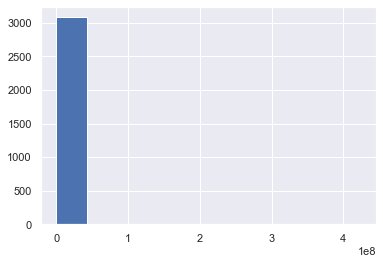

In [30]:
s_switch_re.hist()

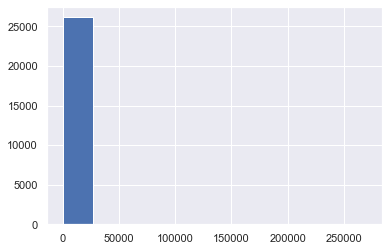

In [25]:
s_load_mapping_re.hist()

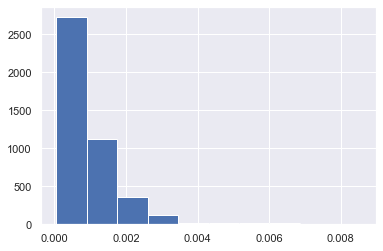

In [26]:
s_cos_phi_re.hist()

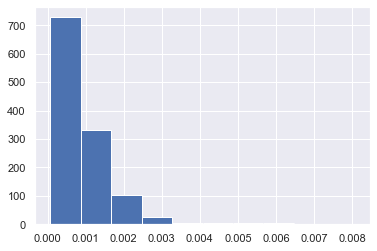

In [27]:
s_normal_re.hist()

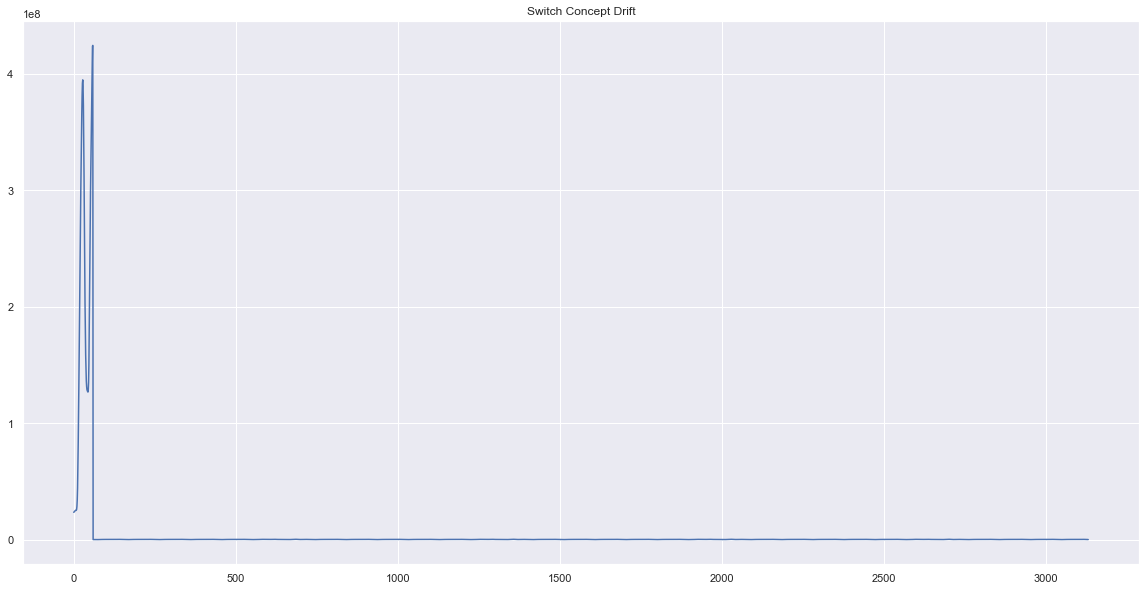

In [82]:
s_switch_re.plot(figsize=(20,10), title='Switch Concept Drift')

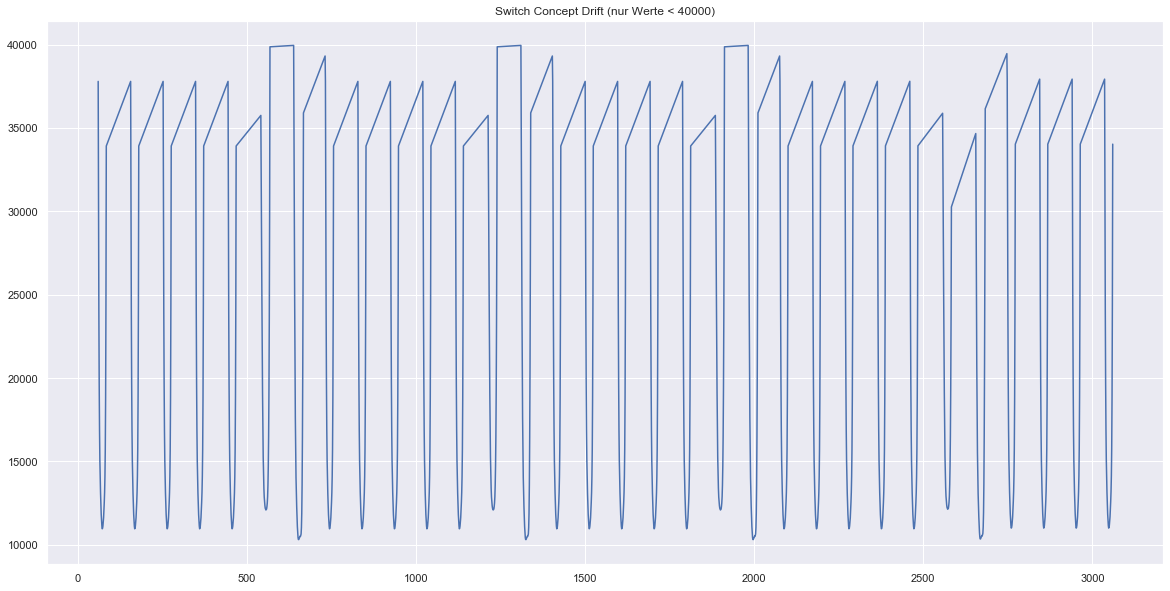

In [83]:
ss = s_switch_re[s_switch_re < 40000]
ss.plot(figsize=(20,10), title='Switch Concept Drift (nur Werte < 40000)')

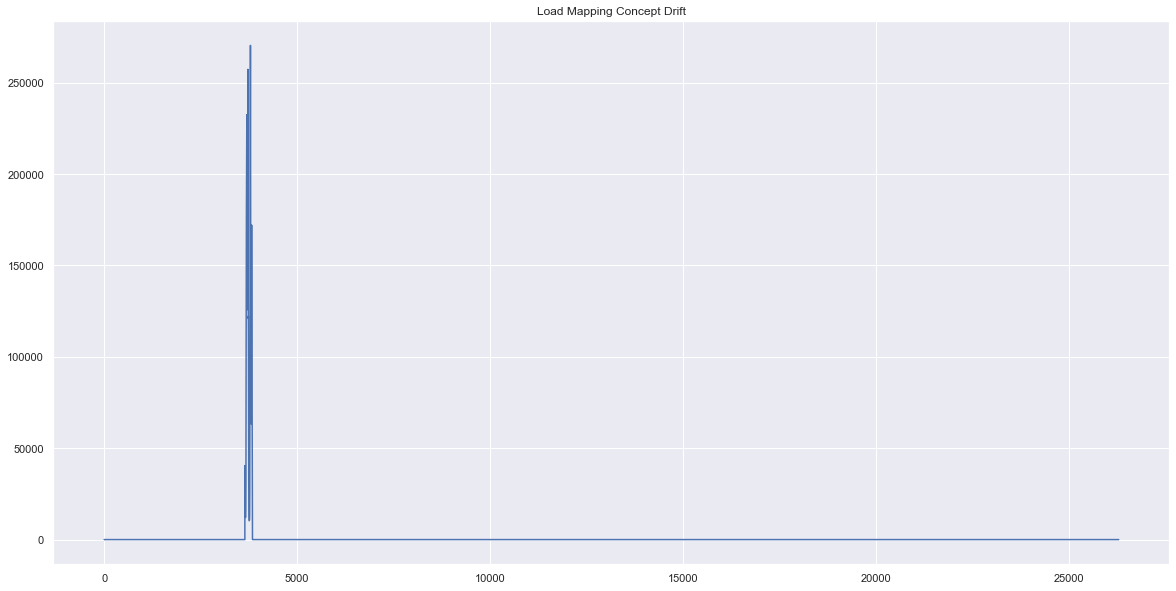

In [84]:
s_load_mapping_re.plot(figsize=(20,10), title='Load Mapping Concept Drift')

In [94]:
ll = s_load_mapping_re.index[s_load_mapping_re > 40000].tolist()
print(ll)

[3648, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838]


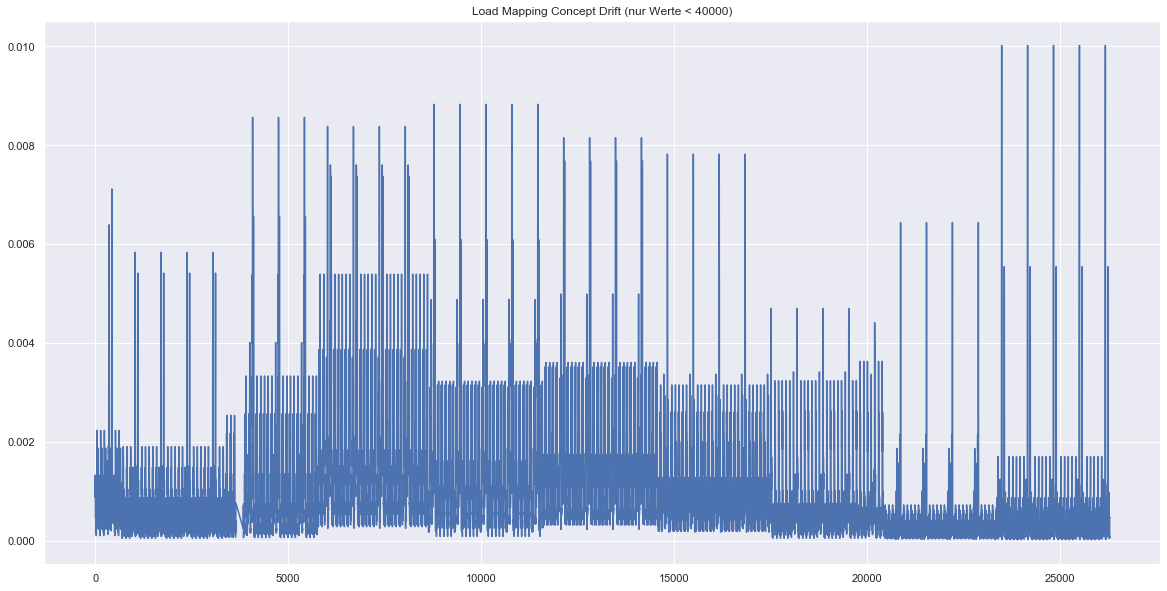

In [92]:
ss = s_load_mapping_re[s_load_mapping_re < 3000]
ss.plot(figsize=(20,10), title='Load Mapping Concept Drift (nur Werte < 40000)')

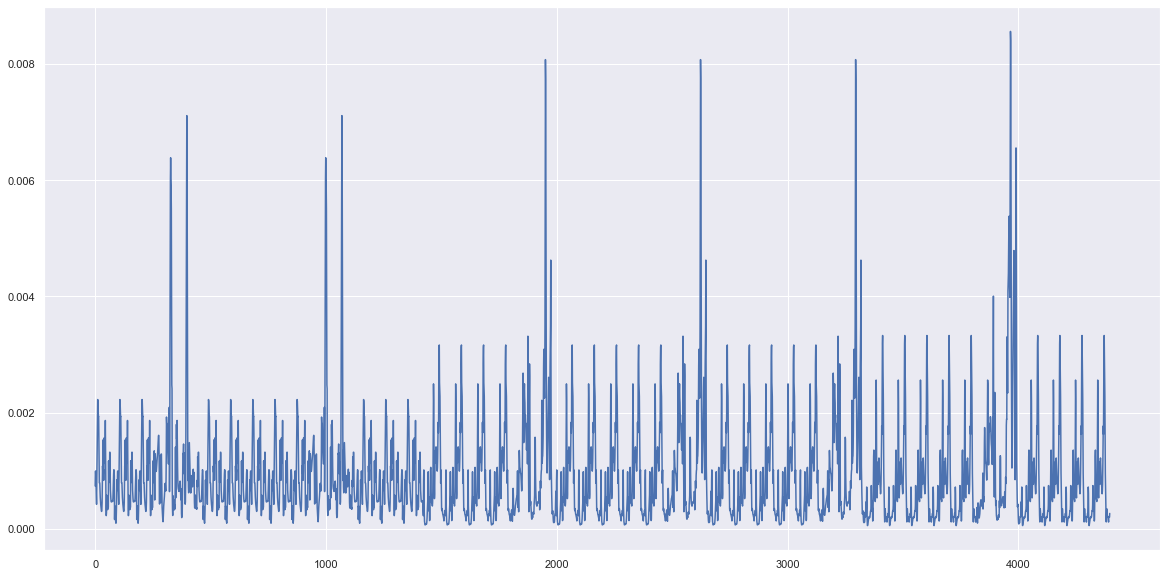

In [55]:
s_cos_phi_re.plot(figsize=(20,10))

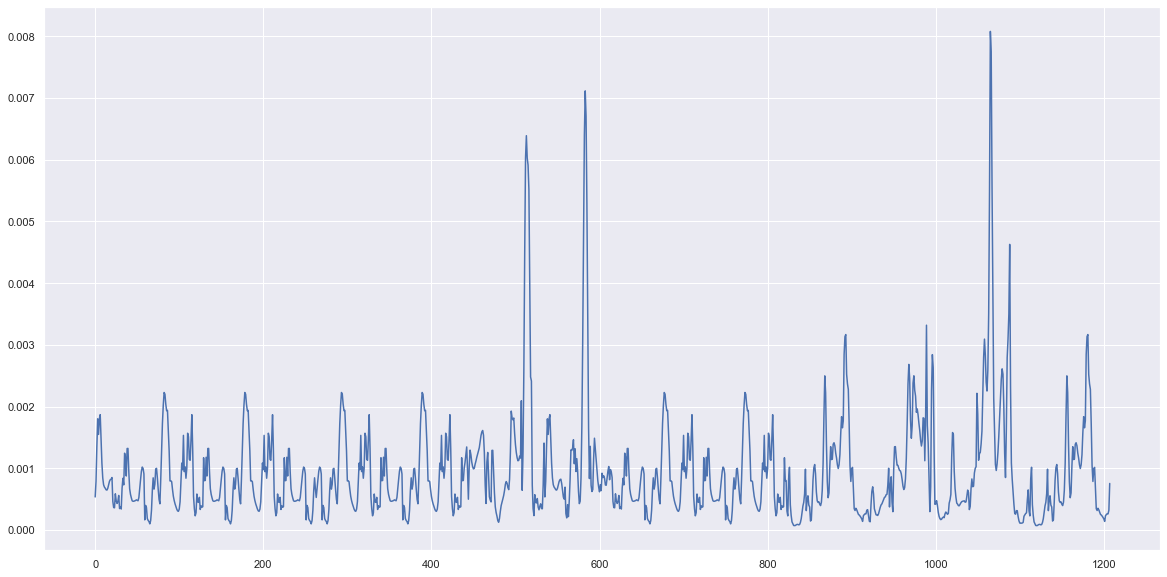

In [56]:
s_normal_re.plot(figsize=(20,10))